In [329]:
# ==========================================================
# Standard library imports
# ==========================================================
import os
import sys
import time

# ==========================================================
# Third-party library imports
# ==========================================================
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.interpolate import RegularGridInterpolator

# ==========================================================
# Local utility imports
# ==========================================================
# Set up paths for utility imports
current_dir = os.getcwd()
utilities_dir = os.path.join(current_dir, '../../utils')

# Ensure the utilities directory is in the import path
sys.path.insert(0, utilities_dir)
from plotting import *

# Return to the original working directory
os.chdir(current_dir)

# Torch device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device) 

import plotting   
import importlib
importlib.reload(plotting)

Using device: cuda


<module 'plotting' from '/home/orincon/Review-Seismic-Waves/main/05_PINNs_helmholz2D/../../utils/plotting.py'>

Epoch 0: Loss = 2.4661e+04
Epoch 500: Loss = 2.3824e+04
Epoch 1000: Loss = 1.9715e+04
Epoch 1500: Loss = 7.6551e+03
Epoch 2000: Loss = 2.0077e+03
Epoch 2500: Loss = 1.1072e+03
Epoch 3000: Loss = 6.9278e+02
Epoch 3500: Loss = 4.7676e+02
Epoch 4000: Loss = 3.5537e+02
Epoch 4500: Loss = 2.8433e+02
[L-BFGS] Iteration 0: Loss = 2.3022e+02
[L-BFGS] Iteration 500: Loss = 1.1431e-01
[L-BFGS] Iteration 1000: Loss = 2.5500e-02
[L-BFGS] Iteration 1500: Loss = 9.6233e-03
[L-BFGS] Iteration 2000: Loss = 4.8009e-03
Relative L2 error: 9.0417e-04


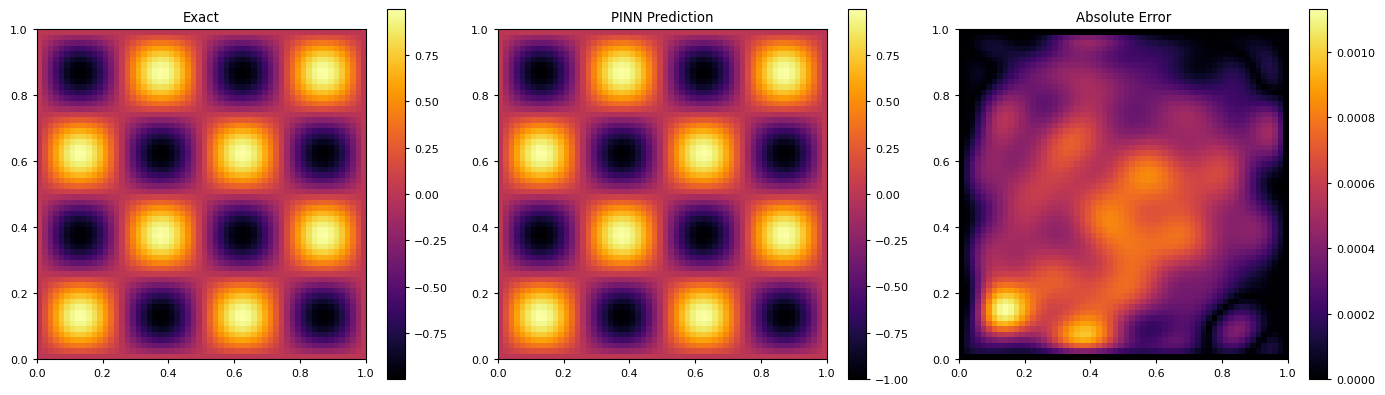

In [ ]:
 

# =====================================================
# 1. Exact solution and RHS
# =====================================================
def f_exact(x, y):
    return np.sin(4 * np.pi * x) * np.sin(4 * np.pi * y)

def rhs(x, y):
    return -2 * (4 * np.pi)**2 * np.sin(4 * np.pi * x) * np.sin(4 * np.pi * y)


# =====================================================
# 2. Sine activation + Hard-constrained PINN
# =====================================================
class Sine(nn.Module):
    def forward(self, input):
        return torch.sin(input)

class PINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        layer_list = []
        for i in range(len(layers) - 1):
            layer_list.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers) - 2:
                layer_list.append(Sine())
        self.model = nn.Sequential(*layer_list)

    def forward(self, x, y):
        inputs = torch.cat([x, y], dim=1)
        u_hat = self.model(inputs)
        # Hard constraint: 
        return x*(1 - x) *y* (1 - y) * u_hat


# =====================================================
# 3. Sampling points
# =====================================================
def sample_pinn_points(N_int, device="cpu"):
     
    eps = 1e-6

    # Interior points (exclude boundaries)
    x_int = eps + (1 - 2*eps) * torch.rand((N_int, 1), device=device)
    y_int = eps + (1 - 2*eps) * torch.rand((N_int, 1), device=device)
    x_int.requires_grad_(True)
    y_int.requires_grad_(True)

    return x_int, y_int


# =====================================================
# 4. Loss function (only PDE residual, since BC is hard)
# =====================================================
def pinn_loss(model, x_int, y_int):
    f_pred = model(x_int, y_int)

    # Compute derivatives
    grads = torch.autograd.grad(f_pred, [x_int, y_int],
                                grad_outputs=torch.ones_like(f_pred),
                                create_graph=True)
    f_x, f_y = grads
    f_xx = torch.autograd.grad(f_x, x_int, torch.ones_like(f_x), create_graph=True)[0]
    f_yy = torch.autograd.grad(f_y, y_int, torch.ones_like(f_y), create_graph=True)[0]

    # PDE residual: ∇²f = RHS
    rhs_val = rhs(x_int.detach().cpu().numpy(), y_int.detach().cpu().numpy())
    rhs_torch = torch.tensor(rhs_val, dtype=torch.float32, device=device)

    res = f_xx + f_yy - rhs_torch
    return torch.mean(res**2)


# =====================================================
# 5. Training setup
# =====================================================
N = 100
x_int, y_int = sample_pinn_points(N, device=device)

layers = [2, 275, 275, 1]
model = PINN(layers).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = pinn_loss(model, x_int, y_int)
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4e}")

# Refinement with L-BFGS
optimizer_lbfgs = torch.optim.LBFGS(model.parameters(),
                                    max_iter=5000,
                                    tolerance_grad=1e-8,
                                    tolerance_change=1e-9,
                                    history_size=100,
                                    line_search_fn="strong_wolfe")

lbfgs_iter = 0
def closure():
    global lbfgs_iter
    optimizer_lbfgs.zero_grad()
    loss = pinn_loss(model, x_int, y_int)
    loss.backward()
    if lbfgs_iter % 500 == 0:
        print(f"[L-BFGS] Iteration {lbfgs_iter}: Loss = {loss.item():.4e}")
    lbfgs_iter += 1
    return loss

optimizer_lbfgs.step(closure)


# =====================================================
# 6. Evaluate on grid and compute error
# =====================================================
nx, ny = 60, 60
xg = np.linspace(0, 1, nx)
yg = np.linspace(0, 1, ny)
X, Y = np.meshgrid(xg, yg)
XY_torch = torch.tensor(np.column_stack([X.flatten(), Y.flatten()]),
                        dtype=torch.float32, device=device)

with torch.no_grad():
    f_pred = model(XY_torch[:, 0:1], XY_torch[:, 1:2]).cpu().numpy().reshape(ny, nx)

f_true = f_exact(X, Y)
error_rel = np.linalg.norm(f_pred - f_true, 2) / np.linalg.norm(f_true, 2)
print(f"Relative L2 error: {error_rel:.4e}")

# =====================================================
# 7. Plot
# =====================================================
fig, axs = plt.subplots(1, 3, figsize=(14,4))
im0 = axs[0].imshow(f_true, extent=[0,1,0,1], origin='lower', cmap='inferno')
axs[0].set_title("Exact")
fig.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(f_pred, extent=[0,1,0,1], origin='lower', cmap='inferno')
axs[1].set_title("PINN Prediction")
fig.colorbar(im1, ax=axs[1])

im2 = axs[2].imshow(np.abs(f_pred - f_true), extent=[0,1,0,1], origin='lower', cmap='inferno')
axs[2].set_title("Absolute Error")
fig.colorbar(im2, ax=axs[2])

plt.tight_layout()
plt.show()


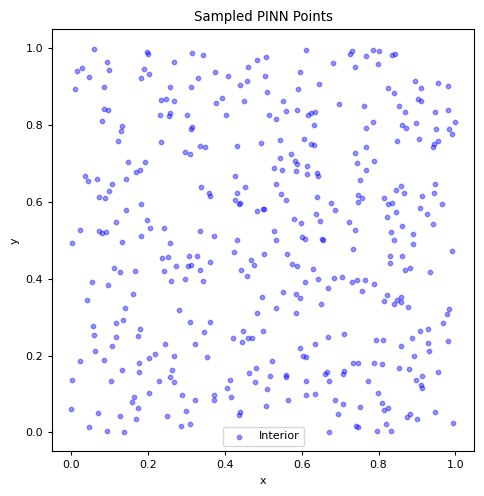

In [334]:
def sample_pinn_points(N, device="cpu"):
    N_int = N * N #- 4 * N
    eps = 1e-6

    # Interior points (exclude boundaries)
    x_int = eps + (1 - 2*eps) * torch.rand((N_int, 1), device=device)
    y_int = eps + (1 - 2*eps) * torch.rand((N_int, 1), device=device)
    x_int.requires_grad_(True)
    y_int.requires_grad_(True)

    return x_int, y_int

# Sample points
x_int, y_int = sample_pinn_points(20, device=device)

# Plot sampled points
plt.figure(figsize=(5, 5))
plt.scatter(x_int.detach().cpu().numpy(), y_int.detach().cpu().numpy(),
            s=10, color='blue', alpha=0.4, label='Interior')

plt.xlabel('x')
plt.ylabel('y')
plt.axis('square')
plt.title('Sampled PINN Points')
plt.legend()
plt.tight_layout()
plt.show()